In [ ]:
import torch as pt
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets,transforms
import torchvision

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io,color,transform,util
from math import exp
import scipy as sc
from scipy.sparse.linalg import eigsh

In [ ]:
from skimage.color import rgba2rgb

In [ ]:
import os

# PART 1

## Model Initialisation

In [ ]:
weights = torchvision.models.segmentation.FCN_ResNet50_Weights.DEFAULT
model = torchvision.models.segmentation.fcn_resnet50(weights=weights)

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


  0%|          | 0.00/135M [00:00<?, ?B/s]

In [ ]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
model.eval() # Brought to evaluation mode

In [ ]:
# look up table
PASCAL_VOC_CLASSES_COLORS = {
    0: (0, 0, 0),        # Background
    1: (128, 0, 0),      # Aeroplane
    2: (0, 128, 0),      # Bicycle
    3: (128, 128, 0),    # Bird
    4: (0, 0, 128),      # Boat
    5: (128, 0, 128),    # Bottle
    6: (0, 128, 128),    # Bus
    7: (128, 128, 128),  # Car
    8: (64, 0, 0),       # Cat
    9: (192, 0, 0),      # Chair
    10: (64, 128, 0),    # Cow
    11: (192, 128, 0),   # Diningtable
    12: (64, 0, 128),    # Dog
    13: (192, 0, 128),   # Horse
    14: (64, 128, 128),  # Motorbike
    15: (192, 128, 128), # Person
    16: (0, 64, 0),      # Potted plant
    17: (128, 64, 0),    # Sheep
    18: (0, 192, 0),     # Sofa
    19: (128, 192, 0),   # Train
    20: (0, 64, 128)     # TV/Monitor
}

### Testing on a image

#### Ground truth labels

In [ ]:
img = io.imread('/content/drive/MyDrive/PascalVOC/test/Annotations/000068.png')

In [ ]:
img.shape

(375, 500, 4)

In [ ]:
img = img[:,:,:3]

In [ ]:
ground_truth_mask = np.zeros_like(img[:, :, 0])

In [ ]:

ground_truth_mask.shape

(375, 500)

In [ ]:
for class_id, class_color in enumerate(PASCAL_VOC_CLASSES_COLORS.values()):
  mask = np.all(img == class_color, axis=-1) # Creating mask
  ground_truth_mask[mask] = class_id

In [ ]:
ground_truth_mask.shape

(375, 500)

#### Output labels

In [ ]:
img = io.imread('/content/drive/MyDrive/PascalVOC/test/Images/000068.jpg')

In [ ]:
img = preprocess(img)

In [ ]:
img = pt.unsqueeze(img, dim=0)

In [ ]:
out_img =model(img)

In [ ]:
out_img=out_img['out'][0]

In [ ]:
out_img.shape

torch.Size([21, 375, 500])

In [ ]:
out = out_img.argmax(0)

In [ ]:
out.shape

torch.Size([375, 500])

In [ ]:
out = out.numpy()

In [ ]:
colormap = plt.cm.get_cmap("Paired", 21)

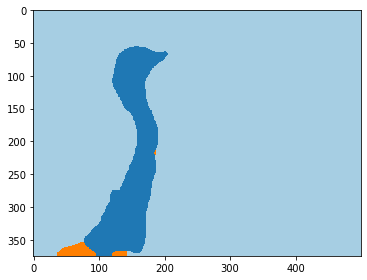

In [ ]:
colored_segmentation = colormap(out) # checking output segments
io.imshow(colored_segmentation)

#### IOU and pixelwise error

In [ ]:
acc = np.mean(out == ground_truth_mask) # Accuracy
print(acc)

0.980288


In [ ]:
# IOU
intersect = np.logical_and(out, ground_truth_mask).sum()
union = np.logical_or(out, ground_truth_mask).sum()
intersect / union

0.8436068077678377

# Creating Dataset

In [ ]:
import os

In [ ]:
with open("/content/drive/MyDrive/PascalVOC/test/test.txt") as file:
  valid_indices = [line.strip() for line in file]

In [ ]:
folder = "/content/drive/MyDrive/PascalVOC/test/Images"
file_names = sorted(os.listdir(folder))
file_paths = [os.path.join(folder, file_name) for file_name in file_names]

In [ ]:
filtered_file_paths = []
for file_path in file_paths:
    base_name, ext = os.path.splitext(os.path.basename(file_path))
    if base_name in valid_indices:
        filtered_file_paths.append(file_path)

In [ ]:
image_files = [io.imread(image_path) for image_path in filtered_file_paths]

In [ ]:
folder = "/content/drive/MyDrive/PascalVOC/test/Annotations"
annot_names = sorted(os.listdir(folder))
annot_paths = [os.path.join(folder, annot_name) for annot_name in annot_names]

In [ ]:
annot_files = [io.imread(annot_path) for annot_path in annot_paths]

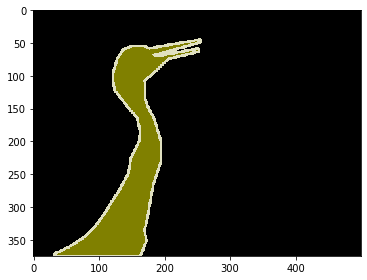

In [ ]:
io.imshow(annot_files[0])

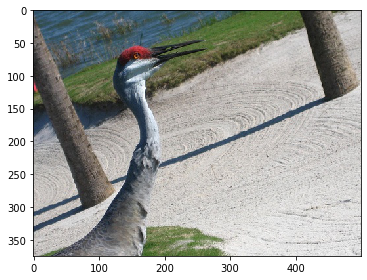

In [ ]:
io.imshow(image_files[0])

### Creating testloaders and testing on ResNet50

In [ ]:
# Custom dataset
class SegmentationDataset(Dataset):
    def __init__(self, image_files, annotation_files, lookup_table, transform=None):
        self.image_files = image_files
        self.annotation_files = annotation_files
        self.lookup_table = lookup_table
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = self.image_files[idx]
        annotation = self.annotation_files[idx]
        annotation = annotation[:,:,:3]
        mask = np.zeros_like(annotation[:, :, 0])
        
        for label, color in self.lookup_table.items():
          m = np.all(annotation == color, axis=-1)
          mask[m] = label
        # for label, color in self.lookup_table.items():
        #     mask[np.where(annotation == color)] = label

        

        if self.transform:
            image = self.transform(image)
            #mask = self.transform(mask)

        return image, mask

In [ ]:
dataset = SegmentationDataset(image_files, annot_files, PASCAL_VOC_CLASSES_COLORS, preprocess)
data_loader = pt.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

In [ ]:
def find_iou(pred, target, num_classes): # Function to calculate IOU
    ious = []
    for class_id in range(num_classes):
        intersection = (pred == class_id) & (target == class_id)
        union = (pred == class_id) | (target == class_id)
        if union.sum()!=0:
          iou = intersection.sum() / union.sum()
          ious.append(iou)
    return np.mean(ious)

In [ ]:
# Evaluating model on test set
net_accs = []
net_iou = []
for i, (images, targets) in enumerate(data_loader):
  out_img=model(images)
  out_img=out_img['out'][0]
  out = out_img.argmax(0)
  out = out.numpy()
  targets = pt.squeeze(targets)
  ans = targets.numpy()
  acc = np.mean(out == ans)
  iou = find_iou(out,ans,21)
  net_accs.append(acc)
  net_iou.append(iou)


In [ ]:
np.mean(net_accs) # Mean Accuracy

0.9163349391005375

In [ ]:
np.mean(net_iou) # Mean IOU

0.6400260908862386

# Part 3

## Image 4 segmentation using FCN

In [ ]:
img = io.imread('/content/drive/MyDrive/test_images/test4.jpg')

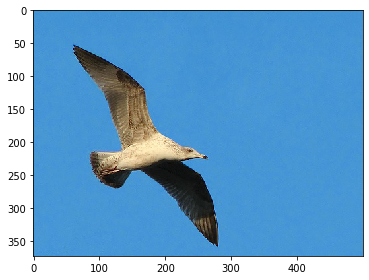

In [ ]:
io.imshow(img)

In [ ]:
img = preprocess(img)

In [ ]:
img = pt.unsqueeze(img, dim=0)

In [ ]:
out_img =model(img)

In [ ]:
out_img=out_img['out'][0]

In [ ]:
out_img.shape

torch.Size([21, 373, 500])

In [ ]:
out = out_img.argmax(0)

In [ ]:
out = out.numpy()

In [ ]:
colormap = plt.cm.get_cmap("Paired", 21)

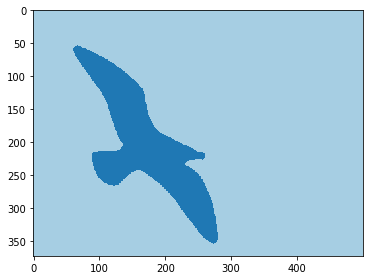

In [ ]:
colored_segmentation = colormap(out)
io.imshow(colored_segmentation)

## Image 5 segmentation using FCN

In [ ]:
img = io.imread('/content/drive/MyDrive/test_images/test5.jpg')

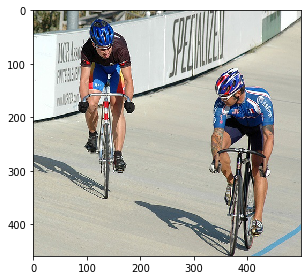

In [ ]:
io.imshow(img)

In [ ]:
img = preprocess(img)

In [ ]:
img = pt.unsqueeze(img, dim=0)

In [ ]:
out_img =model(img)

In [ ]:
out_img=out_img['out'][0]

In [ ]:
out = out_img.argmax(0)

In [ ]:
out = out.numpy()

In [ ]:
colormap = plt.cm.get_cmap("Paired", 21)

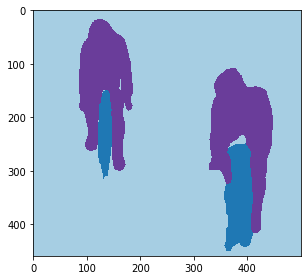

In [ ]:
colored_segmentation = colormap(out)
io.imshow(colored_segmentation)

## Rotated image 4 segmentation

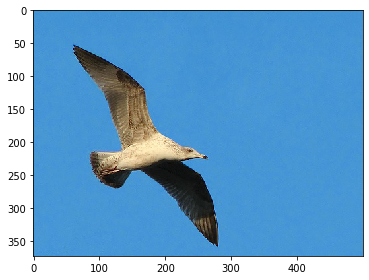

In [ ]:
img = io.imread('/content/drive/MyDrive/test_images/test4.jpg')
io.imshow(img)

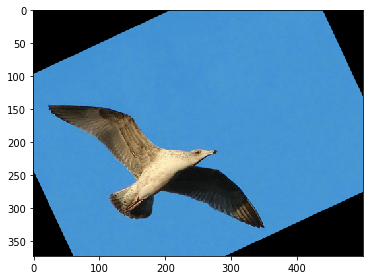

In [ ]:
img = transform.rotate(img,angle = 25)
io.imshow(img)

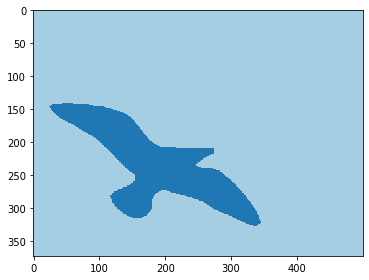

In [ ]:
img = preprocess(img)
img = pt.unsqueeze(img, dim=0)
img =img.to(dtype=pt.float32) # To convert to float 32 format from float 64 format
out_img =model(img)
out_img=out_img['out'][0]
out = out_img.argmax(0)
out = out.numpy()
colormap = plt.cm.get_cmap("Paired", 21)
colored_segmentation = colormap(out)
io.imshow(colored_segmentation)

## Rotated image 5 segmentation

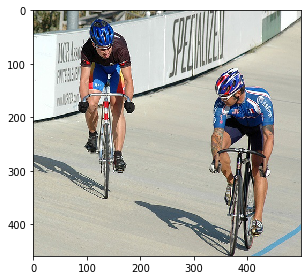

In [ ]:
img = io.imread('/content/drive/MyDrive/test_images/test5.jpg')
io.imshow(img)

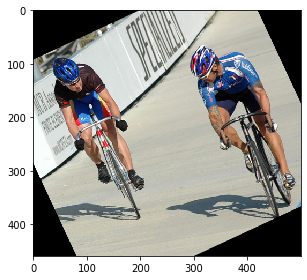

In [ ]:
img = transform.rotate(img,angle = 25)
io.imshow(img)

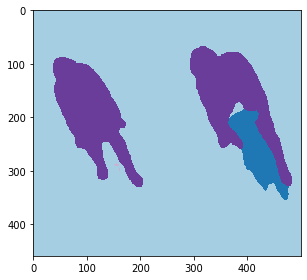

In [ ]:
img = preprocess(img)
img = pt.unsqueeze(img, dim=0)
img =img.to(dtype=pt.float32)
out_img =model(img)
out_img=out_img['out'][0]
out = out_img.argmax(0)
out = out.numpy()
colormap = plt.cm.get_cmap("Paired", 21)
colored_segmentation = colormap(out)
io.imshow(colored_segmentation)

## Gaussian noise added image 4 segmentation

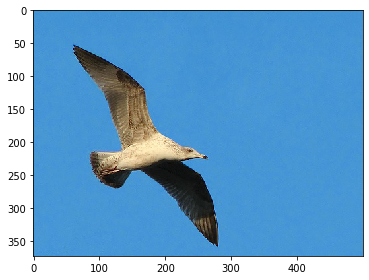

In [ ]:
img = io.imread('/content/drive/MyDrive/test_images/test4.jpg')
io.imshow(img)

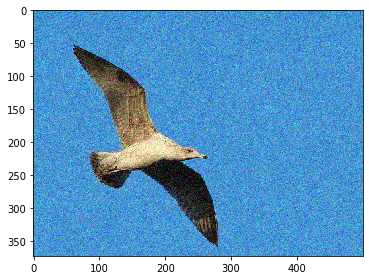

In [ ]:
img = util.random_noise(img, mode='gaussian', var=0.01)
io.imshow(img)

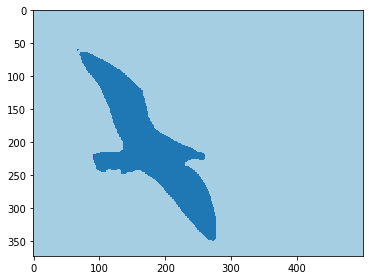

In [ ]:
img = preprocess(img)
img = pt.unsqueeze(img, dim=0)
img =img.to(dtype=pt.float32)
out_img =model(img)
out_img=out_img['out'][0]
out = out_img.argmax(0)
out = out.numpy()
colormap = plt.cm.get_cmap("Paired", 21)
colored_segmentation = colormap(out)
io.imshow(colored_segmentation)

## Gaussian noise added image 5 segmentation

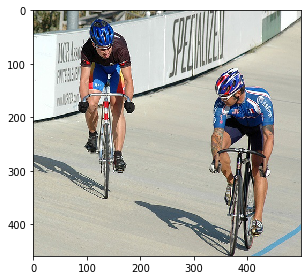

In [ ]:
img = io.imread('/content/drive/MyDrive/test_images/test5.jpg')
io.imshow(img)

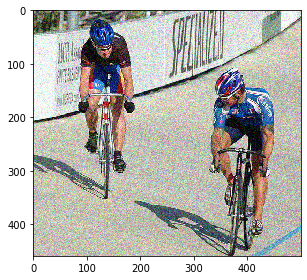

In [ ]:
img = util.random_noise(img, mode='gaussian', var=0.01)
io.imshow(img)

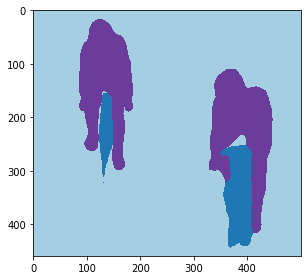

In [ ]:
img = preprocess(img)
img = pt.unsqueeze(img, dim=0)
img =img.to(dtype=pt.float32)
out_img =model(img)
out_img=out_img['out'][0]
out = out_img.argmax(0)
out = out.numpy()
colormap = plt.cm.get_cmap("Paired", 21)
colored_segmentation = colormap(out)
io.imshow(colored_segmentation)